# Model heads

I have developed this Jupyter Notebook for postprocessing and visualizing model outputs (MODFLOWF-NWT using SFR and UZF packages).

Currently, plotting results for uzf_Mar17

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import flopy
import shapefile as shp
from utils import utils

In [2]:
params = dict(start_date='2014-11-01',
              end_date='2016-10-31')

In [3]:
reifn = os.path.abspath('c:/Dropbox/phd/03_model_2017_06_01/mf_models_Mar17/sfr_uzf_rasmus_24Mar17_results_07Apr17/cal_sfruzf.rei9')
reidf = pd.read_csv(reifn,delim_whitespace=True,skiprows=2)
hydfn = os.path.abspath('c:/Dropbox/phd/03_model_2017_06_01/mf_models_Mar17/sfr_uzf_rasmus_24Mar17_bpa/ss_mf.hyd')
catchment_shp = os.path.join('catchment_polygon.shp')

## plot one2one heads

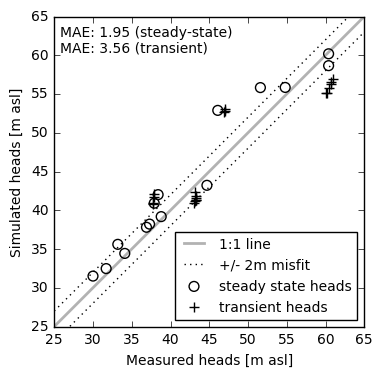

In [4]:
fig,ax = plt.subplots(figsize=(4,4))
#select steady-state heads
state_state_rei = reidf[(reidf['Group'] == 'ssnewhead') | (reidf['Group'] == 'ssoldhead')].copy()
steady_state_measured = state_state_rei['Measured']
steady_state_modelled = state_state_rei['Modelled']
steady_state_mean_absolute_error = np.mean(np.abs(state_state_rei['Residual']))
ax.scatter(steady_state_measured,steady_state_modelled,
           s=50,color='black',marker='o',facecolor='None',label='steady state heads')
#select transient heads
transient_rei = reidf[(reidf['Group'] == 'trhead')]
transient_measured = transient_rei['Measured']
transient_modelled = transient_rei['Modelled']
transient_mean_absolute_error = np.mean(np.abs(transient_rei['Residual']))
ax.scatter(transient_measured,transient_modelled,
           s=50,color='black',marker='+',facecolor='Black',
           label='transient heads')
#set limits etc
lims = ax.get_ylim() + ax.get_xlim()
mn, mx = np.min(lims), np.max(lims)
ax.set_xlim(mn, mx)
ax.set_ylim(mn, mx)
#make 1:1 line
ax.plot(np.arange(mn, mx+1), np.arange(mn, mx+1), color='k', lw=2, ls='-',alpha=0.3,label='1:1 line')
misfit_value = 2
ax.plot(np.asarray([mn,mx]), np.asarray([mn,mx])+misfit_value, color='black', lw=1, ls=':',label='+/- {}m misfit'.format(misfit_value))
ax.plot(np.asarray([mn,mx]), np.asarray([mn,mx])-misfit_value, color='black', lw=1, ls=':')
#set labels etc
ax.set_xlabel('Measured heads [m asl]')
ax.set_ylabel('Simulated heads [m asl]')
ax.text(0.02, 0.97, 'MAE: {:.2f} (steady-state)'.format(steady_state_mean_absolute_error),
        va='top',ha='left',transform = ax.transAxes)
ax.text(0.02, 0.92, 'MAE: {:.2f} (transient)'.format(transient_mean_absolute_error),
        va='top',ha='left',transform = ax.transAxes)
#set grid and legend
#ax.grid(color='black', linestyle='--', linewidth=0.5,alpha=0.5)
ax.legend(loc=4,frameon=True,scatterpoints=1,fontsize=10)

#SAVEFIG
utils.mysavefig(myfig=fig,figname='model_heads_one2one.png')

## plot spatial distribution of head residuals

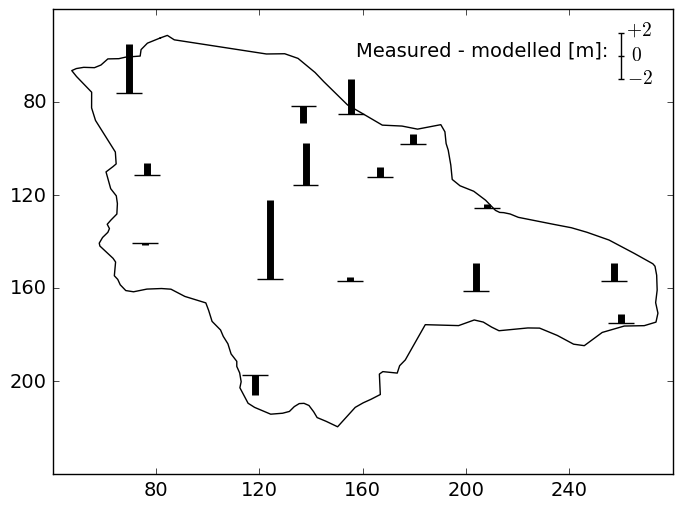

In [5]:
#
spatial_head_distribution = []
head_rei = reidf[(reidf['Group'] == 'ssnewhead') | (reidf['Group'] == 'ssoldhead')][['Name','Residual']].copy()
head_rei['Name2'] = head_rei['Name'].str[5:]
head_rei.columns = ['oldname', 'Residual', 'Name']
head_rei = head_rei.drop('oldname', 1)
hyd_df = pd.read_csv(hydfn, delim_whitespace=True,skiprows=0, usecols=[4,5,6],names=['x','y','Name'])
hyd_df.drop(0,axis=0,inplace=True) # drops needless row
merged_df = hyd_df.merge(head_rei,on='Name') # merges rei and hyd
merged_df['x'] = merged_df['x'].astype('float')/25 # changes 'x' from str to float
merged_df['y'] = 240-merged_df['y'].astype('float')/25 # changes 'x' from str to float
# model domain in UTM coordinates"
(xll, yll, xur, yur) = (471800, 6216500, 478800, 6222500)
#
sf = shp.Reader(catchment_shp)
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    x[:] = [(a - xll)/25 for a in x]
    y[:] = [240-(a - yll)/25 for a in y]
# figure
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(x,y,c='black',lw=1,ls='-')
ax.grid(False)
ax.set_xticks(np.arange(80,280,40))
ax.set_yticks(np.arange(80,240,40))
ax.set_ylim(bottom=240, top=40)
ax.set_xlim(left=40, right=280)
##plot
res_factor = 5
#plot scale
cx,cy = 260,60
ax.vlines(cx,cy-res_factor*2,cy+res_factor*2,color='black',linestyles='solid',linewidth=1)
ax.hlines(cy,cx-1,cx+1,color='black',linestyles='solid',linewidth=1)
ax.hlines(cy+res_factor*2,cx-1,cx+1,color='black',linestyles='solid',linewidth=1)
ax.hlines(cy-res_factor*2,cx-1,cx+1,color='black',linestyles='solid',linewidth=1)
## annotate scale
fs = 14
ax.text(cx-5, cy, 'Measured - modelled [m]:', fontsize=fs,ha='right')
ax.text(cx+2, cy-res_factor*1.8, r'$+2$', fontsize=fs)
ax.text(cx+4, cy+2, r'$0$', fontsize=fs)
ax.text(cx+2.5, cy+res_factor*2.4, r'$-2$', fontsize=fs)
#plot lines
xs = merged_df.x.values
ys = merged_df.y.values
ss = merged_df.Residual.values
for x,y,s in zip(xs,ys,ss):
    #plot vertical lines at each well
    ax.vlines(x=x,ymin=y,ymax=y+s*res_factor,lw=5)
    #plot horizontal lines at each well
    ax.hlines(y=y,xmin=x-5,xmax=x+5,lw=1)
#
ax.tick_params(labelsize=fs)
#SAVEFIG
utils.mysavefig(myfig=fig,figname='model_heads_spatial_residuals.png')